# GAN - MNIST EXAMPLE

In this notebook I will use GAN to generate handwritten digits from random noise. To train the model I use the MNIST dataset, the images size is 28x28 (784), in the range 0-255 (greyscale)


The idea of GAN is to use two networks, the generative network generates candidates while the discriminative network evaluates them. They contest each other.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

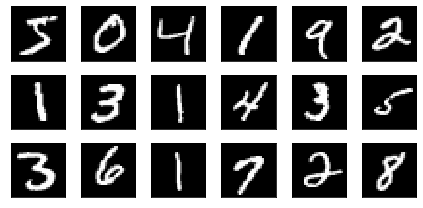

In [22]:
plt.figure(figsize=(6, 3))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Function to create the random noise

In [0]:
def make_random_samples(n_samples, sample_size):
    
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [24]:
sample = make_random_samples(1, 100)
sample

array([[ 1.7399431 , -0.50846882, -0.83818449,  0.77345711, -0.47640266,
         0.11445298, -0.91790651, -0.16422563,  0.99830916,  0.60581005,
        -0.71450813, -1.35537506,  1.53782334,  0.89572892,  0.44000124,
         1.05261126,  0.63459736,  0.03753486,  0.14414193,  0.68734338,
         0.2170974 , -0.40900869,  0.48699261, -0.20571331, -1.39094543,
         0.51019607,  0.52583387,  0.75767782, -0.75541196, -0.36659992,
         0.15547718,  0.38323531, -0.31763489, -0.40071134,  0.62616409,
        -1.37807959,  1.38810121, -1.39520977,  0.29936741, -0.29775437,
        -0.31111561,  0.99853873,  0.59863869, -0.24730348, -0.69986503,
         0.04179892,  0.33979317,  1.24992398, -0.34082492,  1.83418343,
        -2.07602335, -2.48042429, -0.44081153, -0.09943688,  1.20195683,
         1.96794533, -0.03932505,  0.42121165,  1.10859663,  0.90326493,
         1.29508861, -1.93250136,  0.51941418,  1.20680692,  0.7653375 ,
        -0.53481461, -0.16504235, -0.28919821,  2.4

Processing the data,  in this case the range must be -1 to 1 as the generator uses a than activation function

In [0]:
def preprocess(x):    
    x = x.reshape(-1, 784) 
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x



In [0]:
X_train_real = preprocess(x_train)
X_test_real  = preprocess(x_test)

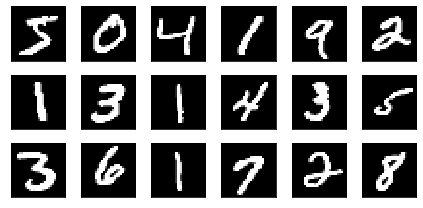

In [27]:
plt.figure(figsize=(6, 3))
for i in range(18):
    plt.subplot(3, 6, i+1)
    img = deprocess(X_train_real[i])
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Labels are: 0 = FAKE and 1 = REAL

In [0]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

Activation Funtions, BIAS and Optimizer

In [0]:
def leaky_relu(net, name=None):
    return tf.maximum(0.01 * net, net, name=name)

def tanh(net, name=None):
    return tf.nn.tanh(net, name=None)

def sigmoid(net, name=None):
    return tf.math.sigmoid(net, name=None)

he_init = tf.contrib.layers.variance_scaling_initializer()

#Adam
def adamOptimizer(lr):

    decay_momentum = 0.875
    decay_scaling = 0.99898989898
    epsilon = 6.626e-4   #Planck constant: 6.626069934(89)×10−34
    optimizer = tf.train.AdamOptimizer(learning_rate=lr,
                                       beta1=decay_momentum,
                                       beta2=decay_scaling,
                                       epsilon=epsilon)
    return optimizer

# Build network

In [0]:
def createNNfromTopology(topology, activation):
    layers = []
    out = 0
    input = 0
    
    
    for i in range(1,len(topology)):
        input = topology[i-1]
        out = topology[i]
        if i == len(topology)-1:
           
            layers.append(tf.keras.layers.Dense(out, activation=activation,input_shape=(input,),kernel_initializer = he_init))
        else:
            
            layers.append(tf.keras.layers.Dense(out, activation=leaky_relu,input_shape=(input,),kernel_initializer = he_init))
        #print(layers[i-1].get_config())
    
    
    return layers                    
                      

In [0]:
def CreateGan(gen_topology, dis_topology, gl,dl):
    

    gen_model = tf.keras.Sequential(createNNfromTopology( gen_topology, tanh),name="gen")
    gen_model.summary()

    
    
    #discriminator
    dis_model = tf.keras.Sequential(createNNfromTopology(dis_topology, sigmoid), name="dis")
    dis_model.summary()
   
    #gan
    gan = tf.keras.Sequential([
    gen_model,
    dis_model], name="gan")

    gan.summary()
     
    
    dis_model.compile(optimizer=adamOptimizer(dl), loss='binary_crossentropy')
    gan.compile(optimizer=adamOptimizer(gl), loss='binary_crossentropy')
    
    return gan, gen_model, dis_model
    

In some cases it is not needed to train the discriminator

In [0]:
def make_trainable(model, trainable):
    
    for layer in model.layers:
        layer.trainable = trainable        

# Hyperparameters

In [0]:
sample_size     = 100     
image_size      = 784
g_lr            = 0.0001  # Generator learning rate
d_lr            = 0.001   # Discriminator learning rate
epochs          = 150
batch_size      = 64      # train batch size
eval_size       = 32      # evaluate size
smooth          = 0.1

g_topology = [sample_size, 128, 256,   image_size] 
d_topology = [image_size,256, 128, 64,   1] 

# Training

In [34]:
# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)




# create a GAN, a generator and a discriminator

gan, gen_model, dis_model = CreateGan(g_topology, d_topology,g_lr,d_lr)

losses = []
samples = []

for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_random_samples(batch_size, sample_size)
        X_batch_fake = gen_model.predict_on_batch(latent_samples)
        
        
        
        # train the discriminator to detect real and fake images
        make_trainable(dis_model, True)        
        dis_model.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        dis_model.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(dis_model, False)     
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_random_samples(eval_size, sample_size)
    X_eval_fake = gen_model.predict_on_batch(latent_samples)
    
    samples.append(X_eval_fake)

    d_loss  = dis_model.test_on_batch(X_eval_real, y_eval_real)
    d_loss += dis_model.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

Model: "gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               201488    
Total params: 247,440
Trainable params: 247,440
Non-trainable params: 0
_________________________________________________________________
Model: "dis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
____________________________________________

# Training analysis

Images generated by the Generator at the last epoch

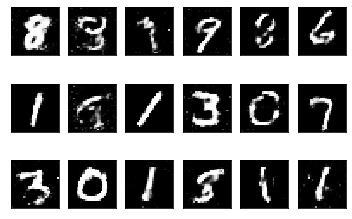

In [35]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots( nrows=3, ncols=6, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

_ = view_samples(-1, samples)

Images generaded by the Generator Network every 10 epochs

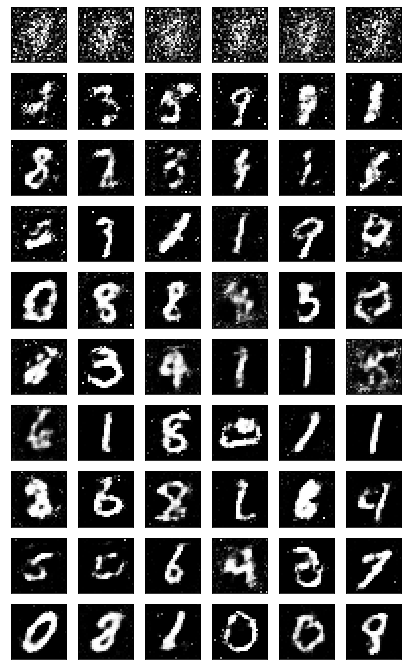

In [36]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Loss

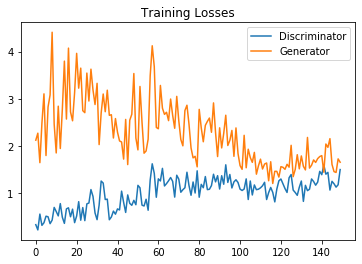

In [37]:

losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

# Generator model test

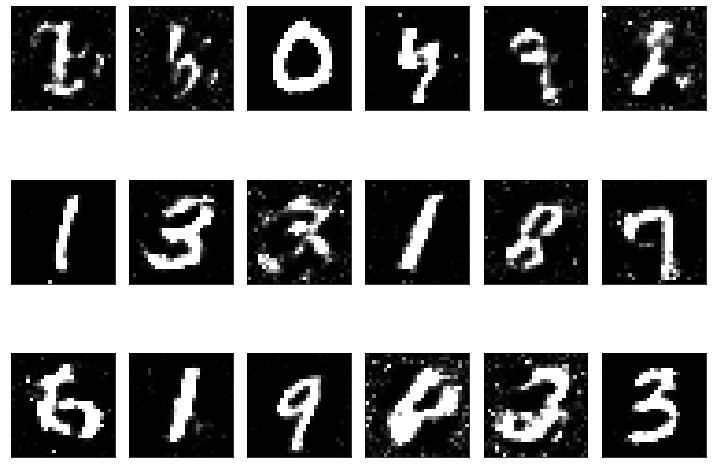

In [38]:
latent_samples = make_random_samples(18, sample_size)
generated_digits = gen_model.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(18):
    img = deprocess(generated_digits[i])
    plt.subplot(3, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()